In [1]:
from pathlib import Path
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch
import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt

In [2]:
torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model device setup: {device}")
extractor = SuperPoint(max_num_keypoints=2000).eval().to(device)
matcher = LightGlue(features="superpoint").eval().to(device)
img_ref = "2.ppm"

Model device setup: cuda


In [3]:
def random_homography(h, w, max_angle=20, max_scale=0.15, max_shift=0.05):
    # Coordenadas normalizadas dos cantos
    pts1 = np.float32([[0,0], [w,0], [w,h], [0,h]])

    # Parâmetros aleatórios
    angle = np.deg2rad(np.random.uniform(-max_angle, max_angle))
    scale = 1.0 + np.random.uniform(-max_scale, max_scale)
    tx = np.random.uniform(-max_shift, max_shift) * w
    ty = np.random.uniform(-max_shift, max_shift) * h

    # Matriz de rotação + escala
    R = np.array([
        [np.cos(angle)*scale, -np.sin(angle)*scale, tx],
        [np.sin(angle)*scale,  np.cos(angle)*scale, ty],
        [0, 0, 1]
    ])

    # Pequeno deslocamento perspectivo (efeito 3D planar)
    persp = np.array([
        [1, 0, np.random.uniform(-1e-4, 1e-4)],
        [0, 1, np.random.uniform(-1e-4, 1e-4)],
        [np.random.uniform(-1e-7, 1e-7), np.random.uniform(-1e-7, 1e-7), 1]
    ])

    H = persp @ R
    pts2 = cv2.perspectiveTransform(pts1[None, :, :], H)[0]
    return H, pts1, pts2

#Carrega a imagem base
img = cv2.imread(img_ref)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h, w = img_gray.shape

# Gera a homografia aleatória e aplicada a transformação na imagem base
H, pts1, pts2 = random_homography(h, w)
img_warped = cv2.warpPerspective(img, H, (w, h)) #imagem base modificada
img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)

cv2.imwrite("imagem_rgb.ppm", img_warped)
cv2.imwrite("imagem_gray.ppm", img_gray)


True

In [4]:
image0 = load_image(img_ref)
image1 = load_image("imagem_rgb.ppm")
h, w = image0.shape[1:]

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension
kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

kpts0 = kpts0.cpu().numpy().astype(np.float32)
kpts1 = kpts1.cpu().numpy().astype(np.float32)
kpts1_gt = cv2.perspectiveTransform(kpts0[None, :, :], H)[0]
m_kpts0 = m_kpts0.cpu().numpy().astype(np.float32)
m_kpts1 = m_kpts1.cpu().numpy().astype(np.float32)

bounds = (
    (kpts1_gt[:, 0] >= 0) & (kpts1_gt[:, 0] < w) &
    (kpts1_gt[:, 1] >= 0) & (kpts1_gt[:, 1] < h)
)
kpts0_filtered = kpts0[bounds]
kpts1_gt_filtered = kpts1_gt[bounds]

print(f"Keypoints detectados: {kpts0.shape[0]}")
print(f"Matches preditos:     {matches.shape[0]}")
print(f"Ground truth matches: {kpts1_gt_filtered.shape[0]}")

Keypoints detectados: 2000
Matches preditos:     1040
Ground truth matches: 1088


/home/navms-pdi2/anaconda3/envs/matcherz/lib/python3.10/site-packages/lightglue/viz2d.py:116: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(k[:, 0], k[:, 1], c=c, s=ps, linewidths=0, alpha=alpha)


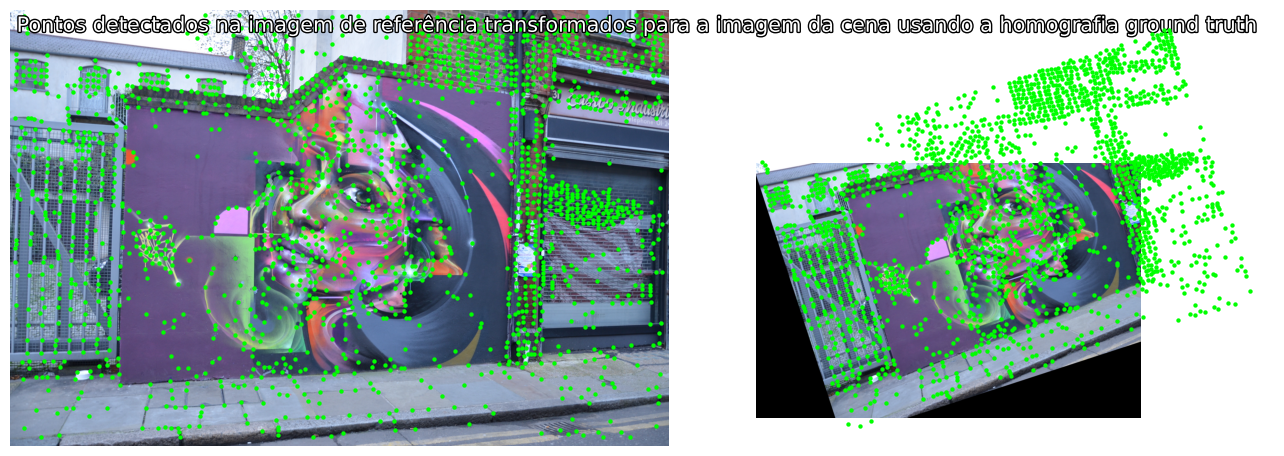

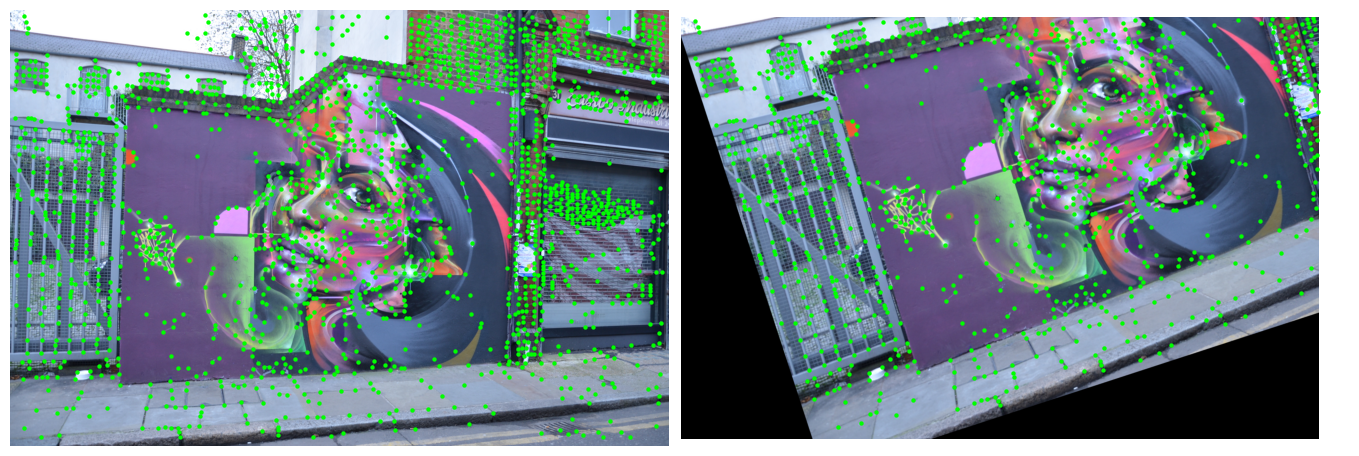

In [5]:
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1_gt], colors=[[0.0, 1.0, 0.0, 1.0],[0.0, 1.0, 0.0, 1.0]], ps=10)
viz2d.add_text(0, f'Pontos detectados na imagem de referência transformados para a imagem da cena usando a homografia ground truth', fs=15)

viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1_gt_filtered], colors=[[0.0, 1.0, 0.0, 1.0],[0.0, 1.0, 0.0, 1.0]], ps=10)

In [16]:






class AUCMetric:
    def __init__(self, thresholds, elements=None):
        # Garante que elements sempre seja uma lista
        self._elements = [] if elements is None else elements
        self.thresholds = thresholds if isinstance(thresholds, list) else [thresholds]

    def cal_error_auc(self, errors, thresholds):
        sort_idx = np.argsort(errors)
        errors = np.array(errors.copy())[sort_idx]
        recall = (np.arange(len(errors)) + 1) / len(errors)
        errors = np.r_[0.0, errors]
        recall = np.r_[0.0, recall]
        aucs = []
        for t in thresholds:
            last_index = np.searchsorted(errors, t)
            r = np.r_[recall[:last_index], recall[last_index - 1]]
            e = np.r_[errors[:last_index], t]
            aucs.append(np.round((np.trapz(r, x=e) / t), 4))
        return aucs

    def update(self, tensor):
        if isinstance(tensor, float):
            tensor = torch.tensor([tensor])
        elif isinstance(tensor, list):
            tensor = torch.tensor(tensor)
        assert tensor.dim() == 1
        self._elements += tensor.cpu().numpy().tolist()

    def compute(self):
        if len(self._elements) == 0:
            return np.nan
        else:
            return self.cal_error_auc(self._elements, self.thresholds)

In [21]:
def compute_mean_reprojection_error(H_est, H_gt, image_shape):
    """
    Calcula o erro médio de reprojeção dos quatro cantos da imagem.
    Args:
        H_est: np.ndarray (3x3) - homografia estimada
        H_gt: np.ndarray (3x3)  - homografia ground truth
        image_shape: (H, W)     - altura e largura da imagem
    Retorna:
        mean_error: float - erro médio de reprojeção (em pixels)
    """
    H, W = image_shape
    # 1. Cantos da imagem em coordenadas homogêneas
    corners = np.array([
        [0, 0, 1],
        [W, 0, 1],
        [0, H, 1],
        [W, H, 1]
    ]).T  # shape (3,4)

    # 2. Projeta os cantos com ambas homografias
    proj_est = H_est @ corners
    proj_gt  = H_gt  @ corners

    # 3. Converte para coordenadas cartesianas
    proj_est /= proj_est[2, :]
    proj_gt  /= proj_gt[2, :]

    # 4. Calcula erro euclidiano por canto
    errors = np.linalg.norm(proj_est[:2, :].T - proj_gt[:2, :].T, axis=1)

    # 5. Retorna erro médio (1 valor por par de imagens)
    return float(np.mean(errors))

# Calcula erro médio
H_gt = H
H_est, _ = cv2.findHomography(m_kpts0, m_kpts1, cv2.RANSAC,5.0)

mean_err = compute_mean_reprojection_error(H_est, H_gt, image0.shape[1:])
print("Mean reprojection error:", mean_err)

# Atualiza e calcula AUC
auc_metric = AUCMetric(thresholds=[1, 5])
auc_metric.update(torch.tensor([mean_err]))
aucs = auc_metric.compute()
print("AUC@1px, AUC@5px:", aucs)



Mean reprojection error: 0.8644568762584562
AUC@1px, AUC@5px: [np.float64(0.5678), np.float64(0.9136)]


/tmp/ipykernel_1679161/909982324.py:18: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aucs.append(np.round((np.trapz(r, x=e) / t), 4))


In [6]:
def compute_metrics(pred, gt, threshold=3.0):
    
    # Calcula erro entre os matches estimados e o ground truth
    dists = np.linalg.norm(gt[:, None, :] - pred[None, :, :], axis=-1)
    min_dists = dists.min(axis=1)
    indices = dists.argmin(axis=1)
    tp_mask = np.where(min_dists < threshold, indices, -1)
    total_estimativas = pred.shape[0]
    total_ground_truth = gt.shape[0]
    
    tp = np.sum(tp_mask != -1) # true positives: matches estimados corretamente
    fp = total_estimativas - tp # false positives: matches estimados incorretamente
    fn = total_ground_truth - tp # false negatives: matches existentes não correspondidos
    errors = min_dists[min_dists < threshold]

    # Métricas
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    mean_error = np.mean(errors) if len(errors) > 0 else np.nan

    return {
        f"precision@{round(threshold)}px": round(precision.copy().tolist()*100,2),
        f"recall@{round(threshold)}px": round(recall.copy().tolist()*100,2),
        "mean_error": round(mean_error.copy().tolist()*100,2),
        "tp": tp.copy().tolist(),
        "fp": fp.copy().tolist(),
        "fn": fn.copy().tolist(),
    }

report = compute_metrics(m_kpts1, kpts1_gt_filtered, threshold=3.0)
report

{'precision@3px': 93.46,
 'recall@3px': 89.34,
 'mean_error': 103.38,
 'tp': 972,
 'fp': 68,
 'fn': 116}

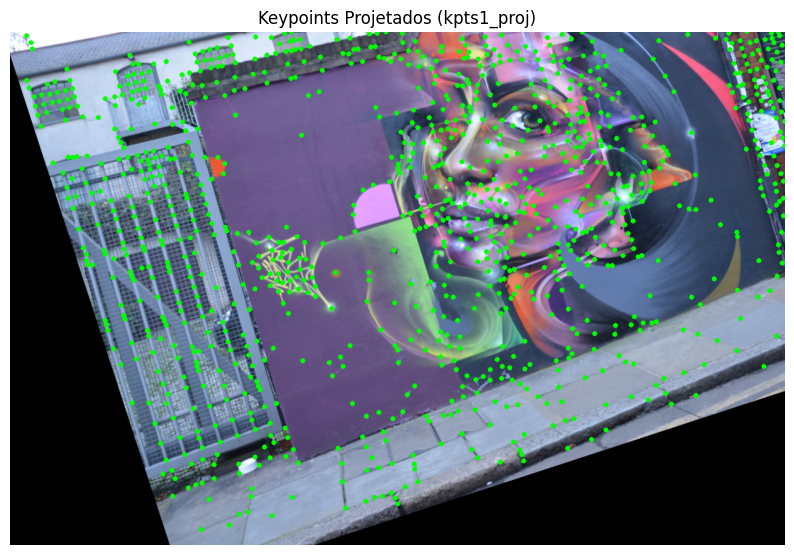

In [7]:
img_draw = cv2.imread("imagem_rgb.ppm")

# Desenha cada ponto projetado
for (x, y) in kpts1_gt_filtered:
    cv2.circle(img_draw, (int(x), int(y)), 4, (0, 255, 0), -1)  # verde

# Mostra com matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
plt.title("Keypoints Projetados (kpts1_proj)")
plt.axis("off")
plt.show()

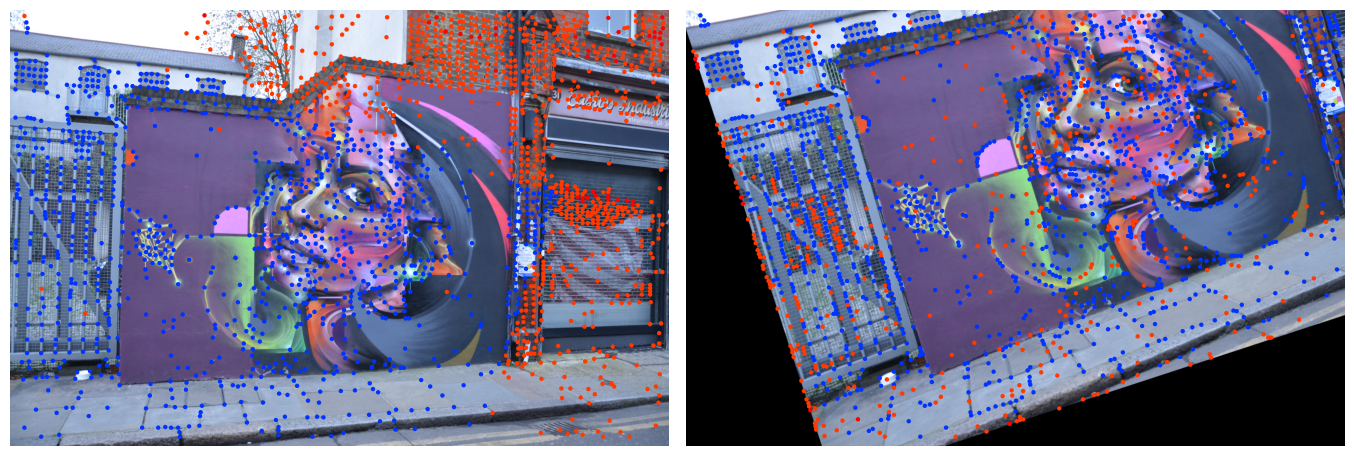

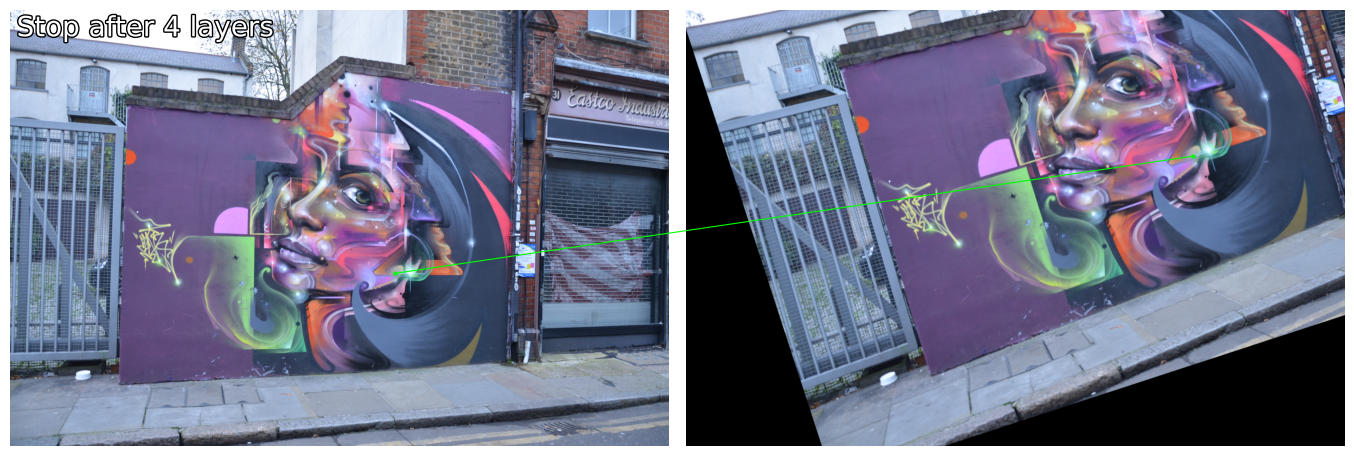

In [8]:
kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0[:1], m_kpts1[:1], color="lime", lw=0.8)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

